In [1]:
import os
import random
random.seed(7)
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.stats import skew
from scipy.stats import kurtosis

# Constants for stride
stride = 50
window = 150

# Constants for reshaping the data before feeding into the network
n_features = 12
n_seq = 150
n_steps = 1

TRAIN_DATA_PATH = 'Training Data B/'
TEST_DATA_PATH = 'Test Data 2/'

def get_session_sets():
    session_ids = get_session_list(TRAIN_DATA_PATH)
    random.shuffle(session_ids)
    
    training = session_ids[0:-2]
    validation = session_ids[-2:]
    
    return training, validation

def get_session_list(path):
    sessions = [x[0].split('/')[1] for x in os.walk(path)]
    sessions = list(filter(lambda x: len(x) > 0, sessions))
    return sessions

def load_session(path, session_name, data_type):
    datapath =  path + session_name + '/'
    t_df = pd.read_csv(datapath + 'time.txt', sep = '\s+', header = None)
    arm = pd.read_csv(datapath + 'armIMU.txt',sep = '\s+', header = None)
    wrist = pd.read_csv(datapath + 'wristIMU.txt', sep = '\s+',header = None)
    observations = pd.concat([arm, wrist], axis = 1)
    
    if (data_type != 'test'):
        labels = pd.read_csv(datapath + 'detection.txt', sep = '\s+',header = None)
    else:
        labels = pd.DataFrame()
    
    return observations, labels

def shape_data(observations, labels):
    X = []
    y = []
    for i in range(window, len(observations), stride):
        X.append(np.ravel(observations.iloc[i-window:i,]))
        if labels.empty:
            continue
        
        label = mode(labels.iloc[i-window:i,])[0]
        y.append(label[0][0])
        
    return pd.DataFrame(X), pd.DataFrame(y)
    


def load_data(sessions, session_type):
    observations = []
    labels = []
    path = TEST_DATA_PATH if session_type == 'test' else TRAIN_DATA_PATH
    
    for session in sessions:
        raw_X, raw_y = load_session(path, session, session_type)
        X, y = shape_data(raw_X, raw_y)
        observations.append(X)
        labels.append(y)

    X = pd.concat(observations)
    y = pd.concat(labels)
    if not y.empty:
        y = np.array(y[[0]]).ravel()
    
    return X, y


def reshape(df):
    return df.values.reshape((df.shape[0], n_steps, n_seq, n_features))
    

In [2]:
training, validation = get_session_sets()

X_train, y_train = load_data(training, 'train')
X_val, y_val = load_data(validation, 'val')

X_train = reshape(X_train)
X_val = reshape(X_val)

print('----- Shape of training data ---------')
print(X_train.shape)
print('--------------------------------------')
print('----- Shape of validation data -------')
print(X_val.shape)
print('--------------------------------------')

----- Shape of training data ---------
(21982, 1, 150, 12)
--------------------------------------
----- Shape of validation data -------
(5332, 1, 150, 12)
--------------------------------------


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout

def getModel():
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None, n_seq, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.5))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', 
                  loss='mse', 
                  metrics = ['accuracy'])
    
    return model

Using TensorFlow backend.


In [8]:
model = getModel()
history = model.fit(X_train, y_train, 
              epochs = 10, 
              batch_size = 250, 
              verbose = 1, 
              validation_data = (X_val, y_val))

Train on 21982 samples, validate on 5332 samples
Epoch 1/10
21982/21982 [==============================] - 10s 461us/step - loss: 0.1745 - acc: 0.7831 - val_loss: 0.1423 - val_acc: 0.8224
Epoch 2/10
21982/21982 [==============================] - 9s 416us/step - loss: 0.1191 - acc: 0.8484 - val_loss: 0.1160 - val_acc: 0.8599
Epoch 3/10
21982/21982 [==============================] - 9s 419us/step - loss: 0.0993 - acc: 0.8732 - val_loss: 0.1147 - val_acc: 0.8569
Epoch 4/10
21982/21982 [==============================] - 9s 417us/step - loss: 0.0877 - acc: 0.8884 - val_loss: 0.1028 - val_acc: 0.8732
Epoch 5/10
21982/21982 [==============================] - 9s 420us/step - loss: 0.0809 - acc: 0.8972 - val_loss: 0.1009 - val_acc: 0.8755
Epoch 6/10
21982/21982 [==============================] - 9s 418us/step - loss: 0.0743 - acc: 0.9074 - val_loss: 0.1041 - val_acc: 0.8738
Epoch 7/10
21982/21982 [==============================] - 9s 416us/step - loss: 0.0693 - acc: 0.9138 - val_loss: 0.1083 - 

In [ ]:
history

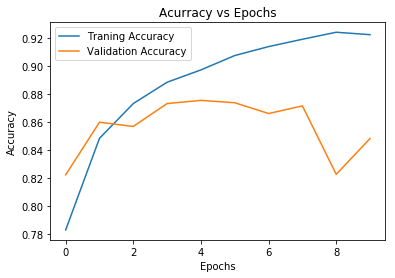

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

plot_name = 'Accuracy'
plt.plot(history.history['acc'], label = 'Traning Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Acurracy vs Epochs')
plt.legend()
plt.savefig('{}.png'.format(plot_name))
plt.show()
plt.clf() 

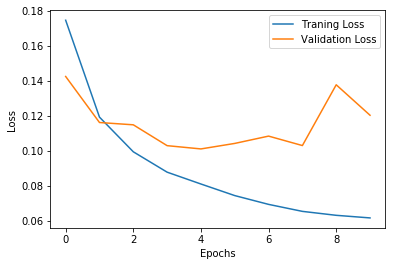

<Figure size 432x288 with 0 Axes>

In [11]:
plot_name = 'Loss'
plt.plot(history.history['loss'], label = 'Traning Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('{}.png'.format(plot_name))
plt.show()
plt.clf() 

In [12]:
def createCSV(session, y, obs):
    result = np.zeros(obs)
    idx = 0
    for label in y:
        for j in range(0, window):
            result[idx + j] = label
        idx += stride
    np.savetxt(TEST_DATA_PATH + session + "/prediction.txt", result, delimiter=",")
    print("CSV Saved")
    return result

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

test_sessions = get_session_list(TEST_DATA_PATH)
for sess in test_sessions:
    raw_X_test, raw_y_test = load_session(TEST_DATA_PATH, sess, 'test')
    X_test, y_test = load_data([sess], 'test')
    X_test = reshape(X_test)
    y_pred = model.predict(X_test)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    createCSV(sess, y_pred, len(raw_X_test))


CSV Saved
CSV Saved
CSV Saved
CSV Saved
